<a href="https://colab.research.google.com/github/likarajo/mnist_digits/blob/master/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train Labels: (60000, 10)
Train Data: (60000, 1, 784)
Test Data: (10000, 1, 784)
Layers -
w1: (784, 50) b1: (50,)
w2: (50, 20) b2: (20,)
w3: (20, 10) b3: (10,)
Training started...
Epoch: 1 Time: 29.45s Train Loss: 0.215983 Test Acc: 0.909300
Epoch: 2 Time: 29.79s Train Loss: 0.101698 Test Acc: 0.926900
Epoch: 3 Time: 29.01s Train Loss: 0.050980 Test Acc: 0.935600
Epoch: 4 Time: 29.17s Train Loss: 0.028961 Test Acc: 0.941700
Epoch: 5 Time: 28.91s Train Loss: 0.016591 Test Acc: 0.946900
Epoch: 6 Time: 29.00s Train Loss: 0.010544 Test Acc: 0.950000
Epoch: 7 Time: 28.90s Train Loss: 0.006283 Test Acc: 0.952600
Epoch: 8 Time: 28.81s Train Loss: 0.005243 Test Acc: 0.954600
Epoch: 9 Time: 29.07s Train Loss: 0.003924 Test Acc: 0.957300
Epoch: 10 Time: 28.79s Train Loss: 0.003059 Test Acc: 0.958500
Total accuracy is 95.85%


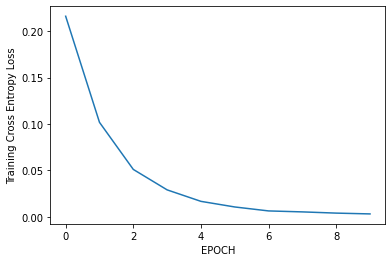

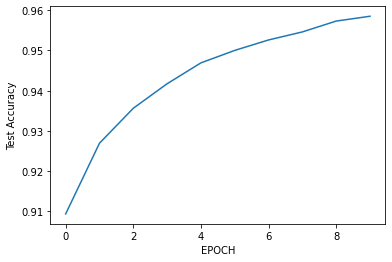

Training Time Taken:  290.9107012748718


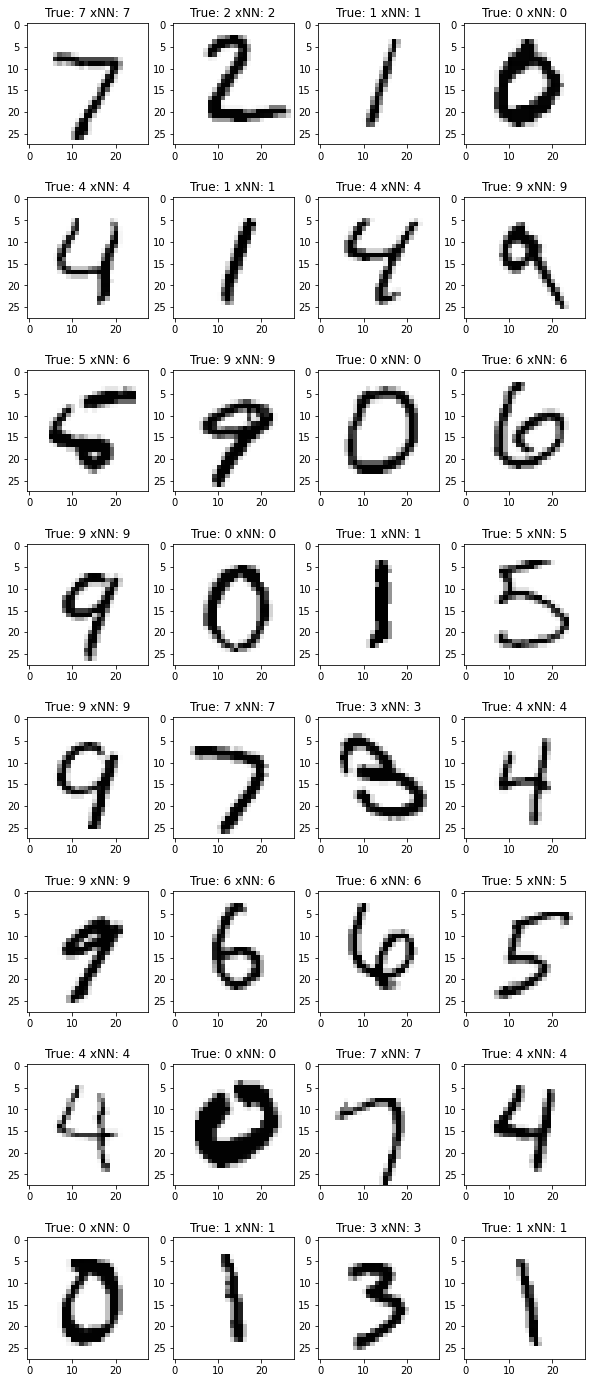

In [23]:
################################################################################
#
# LOGISTICS
#
#    Rajarshi Chattopadhyay
#    RXC170010
#
# DESCRIPTION
#
#    MNIST image classification with an NN written and trained in Python
#
# INSTRUCTIONS
#
#    1. Go to Google Colaboratory: https://colab.research.google.com/notebooks/welcome.ipynb
#    2. File - New Python 3 notebook
#    3. Cut and paste this file into the cell (feel free to divide into multiple cells)
#    4. Runtime - Run all
#
# NOTES
#
#    1. This does not use PyTorch, TensorFlow or any other xNN library
#
#    2. Summary of nn.py
#
# The neural network has 4 layers in total: 1 input layer, 2 hidden layers and 1 output layer. 
# All layers are fully connected.
# Input layer: Input consisting of 28x28 images. We flatten these images to have 28x28=784 nodes.
# Hidden layer 1: 1000 nodes. 
# Hidden layer 2: 100 nodes
# Output layer: Reducing to a total of 10 nodes, so that we can evaluate the nodes against the label. 
# This label is received in the form of an array with 10 elements, where one of the elements is 1, while the rest is 0.
#
#
################################################################################

################################################################################
#
# IMPORT
#
################################################################################

#
# you should not need any import beyond the below
# PyTorch, TensorFlow, ... is not allowed
#

import os.path
import urllib.request
import gzip
import math
import numpy             as np
import matplotlib.pyplot as plt
import time

################################################################################
#
# PARAMETERS
#
################################################################################

# data
DATA_NUM_TRAIN = 60000
DATA_NUM_TEST = 10000
DATA_CHANNELS = 1
DATA_ROWS = 28
DATA_COLS = 28
DATA_CLASSES = 10
DATA_URL_TRAIN_DATA = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
DATA_URL_TRAIN_LABELS = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
DATA_URL_TEST_DATA = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
DATA_URL_TEST_LABELS = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
DATA_FILE_TRAIN_DATA = 'train_data.gz'
DATA_FILE_TRAIN_LABELS = 'train_labels.gz'
DATA_FILE_TEST_DATA = 'test_data.gz'
DATA_FILE_TEST_LABELS = 'test_labels.gz'

# display
DISPLAY_ROWS = 8
DISPLAY_COLS = 4
DISPLAY_COL_IN = 10
DISPLAY_ROW_IN = 25
DISPLAY_NUM = DISPLAY_ROWS * DISPLAY_COLS

################################################################################
#
# DATA
#
################################################################################

# download
if not os.path.exists(DATA_FILE_TRAIN_DATA):
    urllib.request.urlretrieve(DATA_URL_TRAIN_DATA, DATA_FILE_TRAIN_DATA)
if not os.path.exists(DATA_FILE_TRAIN_LABELS):
    urllib.request.urlretrieve(DATA_URL_TRAIN_LABELS, DATA_FILE_TRAIN_LABELS)
if not os.path.exists(DATA_FILE_TEST_DATA):
    urllib.request.urlretrieve(DATA_URL_TEST_DATA, DATA_FILE_TEST_DATA)
if not os.path.exists(DATA_FILE_TEST_LABELS):
    urllib.request.urlretrieve(DATA_URL_TEST_LABELS, DATA_FILE_TEST_LABELS)

# training data
# unzip the file, skip the header, read the rest into a buffer and format to NCHW
file_train_data = gzip.open(DATA_FILE_TRAIN_DATA, 'r')
file_train_data.read(16)
buffer_train_data = file_train_data.read(DATA_NUM_TRAIN * DATA_ROWS * DATA_COLS)
train_data = np.frombuffer(buffer_train_data, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(DATA_NUM_TRAIN, 1, DATA_ROWS, DATA_COLS)

# training labels
# unzip the file, skip the header, read the rest into a buffer and format to a vector
file_train_labels = gzip.open(DATA_FILE_TRAIN_LABELS, 'r')
file_train_labels.read(8)
buffer_train_labels = file_train_labels.read(DATA_NUM_TRAIN)
train_labels = np.frombuffer(buffer_train_labels, dtype=np.uint8).astype(np.int32)

# testing data
# unzip the file, skip the header, read the rest into a buffer and format to NCHW
file_test_data = gzip.open(DATA_FILE_TEST_DATA, 'r')
file_test_data.read(16)
buffer_test_data = file_test_data.read(DATA_NUM_TEST * DATA_ROWS * DATA_COLS)
test_data = np.frombuffer(buffer_test_data, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(DATA_NUM_TEST, 1, DATA_ROWS, DATA_COLS)

# testing labels
# unzip the file, skip the header, read the rest into a buffer and format to a vector
file_test_labels = gzip.open(DATA_FILE_TEST_LABELS, 'r')
file_test_labels.read(8)
buffer_test_labels = file_test_labels.read(DATA_NUM_TEST)
test_labels = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int32)

# debug
# print("Train data", train_data.shape)   # (60000, 1, 28, 28)
# print("Train labels", train_labels.shape) # (60000,)
# print("Test data", test_data.shape)    # (10000, 1, 28, 28)
# print("Test label", test_labels.shape)  # (10000,)


################################################################################
#
# YOUR CODE GOES HERE
#
################################################################################

# Functions

# Activation function
def relu(a, derivative=False):
  if derivative:
    return np.greater(a,0).astype(int)
  else:
    return np.maximum(0,a)

def softmax(X):
  exps = np.exp(X - np.max(X))
  return exps / np.sum(exps)

# Loss function
def cross_entropy(X,y):
    """
    X : (num_examples x num_classes)
    y : (num_examples x 1) computed as y.argmax(axis=1) from one-hot encoded vectors of labels
    """
    m = y.shape[0]
    p = softmax(X)
    log_likelihood = -np.log(p[range(m),y])
    loss = np.sum(log_likelihood) / m
    return loss
  
def delta_cross_entropy(X,y):
    """
    X : (num_examples x num_classes)
    y : (num_examples x 1) computed as y.argmax(axis=1) from one-hot encoded vectors of labels
    """
    m = y.shape[0]
    grad = softmax(X)
    grad[range(m),y] -= 1
    grad = grad/m
    return grad

# Config and hyper parameters

LAYERS_CONFIG = [784, 50, 20, 10]
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Modeling

# one hot encoding labels
one_hot_labels = np.zeros((train_labels.shape[0], 10))
for i in range(train_labels.shape[0]):
    one_hot_labels[i, train_labels[i]] = 1
one_hot_labels = np.array(one_hot_labels, dtype='float32')
print("Train Labels:", one_hot_labels.shape)

# normalize data
train_data = (train_data/255).astype('float32')
test_data = (test_data/255).astype('float32')

# vectorize data
train_data = train_data.reshape(train_data.shape[0],1,28*28)
test_data = test_data.reshape(test_data.shape[0],1,28*28)
print("Train Data:", train_data.shape)
print("Test Data:", test_data.shape)

# initialize weights
w1 = np.random.randn(train_data.shape[2], LAYERS_CONFIG[1])*np.sqrt(1./train_data.shape[2])
b1 = np.random.randn(LAYERS_CONFIG[1])
w2 = np.random.randn(w1.shape[1], LAYERS_CONFIG[2])*np.sqrt(1./w1.shape[1])
b2 = np.random.randn(LAYERS_CONFIG[2])
w3 = np.random.randn(w2.shape[1], LAYERS_CONFIG[3])*np.sqrt(1./w2.shape[1])
b3 = np.random.randn(LAYERS_CONFIG[3])

print("Layers -")
print('w1:', w1.shape, 'b1:', b1.shape)
print('w2:', w2.shape, 'b2:', b2.shape)
print('w3:', w3.shape, 'b3:', b3.shape)


# Training
print("Training started...")

train_loss_list = []
test_acc_list = []

start_time = time.time()

# Iterations
for epoch in range(NUM_EPOCHS):
  s = time.time()

  loss=0
  for i,val in enumerate(train_data):

    # forward pass

    # input layer
    temp_input = np.copy(val)
    # hidden layer 1
    x1 = np.dot(temp_input, w1)
    z1 = np.add(x1,b1)
    a1 = relu(z1)
    # hidden layer 2
    x2 = np.dot(a1, w2)
    z2 = np.add(x2,b2)
    a2 = relu(z2)
    # output layer
    x3 = np.dot(a2, w3)
    z3 = np.add(x3,b3)
    output = softmax(z3)

    # back-propagation

    # output layer loss and derivatives
    dcost_dz3 = output - one_hot_labels[i]
    dz3_dw3 = a2
    dcost_w3 = np.dot(dz3_dw3.T, dcost_dz3)
    dcost_b3 = dcost_dz3
    # hidden layer 2 derivatives
    dz3_da2 = w3
    dcost_da2 = np.dot(dcost_dz3 , dz3_da2.T)
    da2_dz2 = relu(z2, derivative=True)
    dz2_dw2 = a1
    dcost_w2 = np.dot(dz2_dw2.T, da2_dz2 * dcost_da2)
    dcost_b2 = dcost_da2 * da2_dz2
    # hidden layer 1 derivatives
    dcost_dz2 = dcost_da2*da2_dz2
    dz2_da1 = w2
    dcost_da1 = np.dot(dcost_dz2 , dz2_da1.T)
    da1_dz1 = relu(z1, derivative=True)
    dz1_dw1 = temp_input
    dcost_w1 = np.dot(dz1_dw1.T, da1_dz1 * dcost_da1)   
    dcost_b1 = dcost_da1 * da1_dz1

    # weights updates
    lr = LEARNING_RATE
    w1 -= lr * dcost_w1
    b1 -= lr * dcost_b1.sum(axis=0)
    w2 -= lr * dcost_w2
    b2 -= lr * dcost_b2.sum(axis=0)
    w3 -= lr * dcost_w3
    b3 -= lr * dcost_b3.sum(axis=0)

    loss = np.sum(-one_hot_labels[i] * np.log(output))
    # if(i%200 == 0):
    #   print(output)
    #   print("Cost is:", loss)
  
  train_loss_list.append(loss)

  correct = 0
  for i, val in enumerate(test_data):

    # forward pass

    # input layer
    temp_input = np.copy(val)
    # hidden layer 1
    x1 = np.dot(temp_input, w1)
    z1 = np.add(x1, b1)
    a1 = relu(z1)
    # hidden layer 2
    x2 = np.dot(a1, w2)
    z2 = np.add(x2, b2)
    a2 = relu(z2)
    # output layer
    x3 = np.dot(a2, w3)
    z3 = np.add(x3, b3)
    output = softmax(z3)

    if(np.argmax(output) == test_labels[i]):
      correct += 1

  acc = correct/len(test_data)
  test_acc_list.append(acc)

  print('Epoch: {} Time: {:.2f}s Train Loss: {:.6f} Test Acc: {:.6f}'.format(epoch+1, time.time()-s, loss, acc))

time_taken = time.time()-start_time


# Testing (with w and b)

predicted_label_list = []
test_label=[0] * 10
test_count=[0] * 10
for i, val in enumerate(test_data):
  label = test_labels[i]
  test_label[label] += 1

  # forward pass

  # input layer
  temp_input = np.copy(val)
  # hidden layer 1
  x1 = np.dot(temp_input, w1)
  z1 = np.add(x1, b1)
  a1 = relu(z1)
  # hidden layer 2
  x2 = np.dot(a1, w2)
  z2 = np.add(x2, b2)
  a2 = relu(z2)
  # output layer
  x3 = np.dot(a2, w3)
  z3 = np.add(x3, b3)
  output = softmax(z3)
  predicted_label_list.append(np.argmax(output))

  if(np.argmax(output) == test_labels[i]):
    k = test_labels[i]
    test_count[k] += 1

sum=0
sum2 = 0
for i in range(0,10):
  sum = sum + test_count[i]
  sum2= sum2 + test_label[i]
acc = (sum/sum2)*100
print("Total accuracy is {0:.2f}%".format(acc))

# plot of train loss per epoch
plt.plot(list(range(0,NUM_EPOCHS)), train_loss_list)
plt.xlabel('EPOCH')
plt.ylabel('Training Cross Entropy Loss')
plt.show()

# plot of test accuracy per epoch
plt.plot(list(range(0,NUM_EPOCHS)), test_acc_list)
plt.xlabel('EPOCH')
plt.ylabel('Test Accuracy')
plt.show()

# performance display
# total time
print('Training Time Taken: ', time_taken)

# example display
# replace the xNN predicted label with the label predicted by the network
fig = plt.figure(figsize=(DISPLAY_COL_IN, DISPLAY_ROW_IN))
ax  = []
for i in range(DISPLAY_NUM):
    img = test_data[i, :, :].reshape((DATA_ROWS, DATA_COLS))
    ax.append(fig.add_subplot(DISPLAY_ROWS, DISPLAY_COLS, i + 1))
    ax[-1].set_title('True: ' + str(test_labels[i]) + ' xNN: ' + str(predicted_label_list[i]))
    plt.imshow(img, cmap='Greys')
plt.show()